In [73]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

In [74]:
# Wczytaj plik
df_fuel = pd.read_csv('fuel_output.csv', sep=';')
# Wyodrębnij kolumny do zmiennych
#dates = pd.to_datetime(df['Date'])
fuel_data = df_fuel['fuel_data']


fuel_returns = np.log(fuel_data / fuel_data.shift(1)).dropna()

In [75]:
print(fuel_data.tail(100).mean())

2.534375


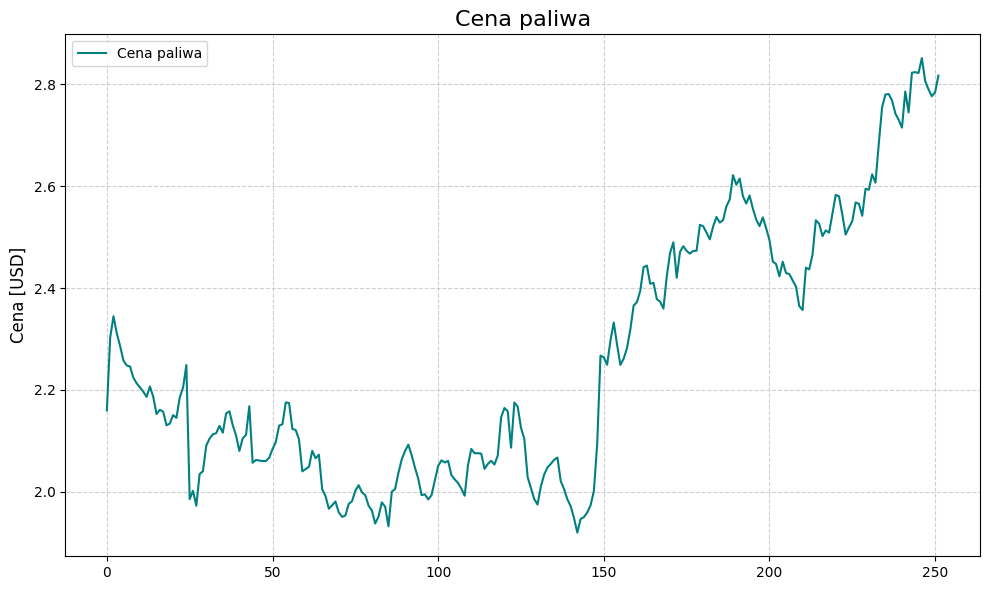

In [76]:
plt.figure(figsize=(10, 6))
plt.plot(fuel_data, color='teal', label='Cena paliwa')
plt.title('Cena paliwa', fontsize=16)
plt.ylabel('Cena [USD]', fontsize=12) 
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()  
plt.show()

# 1.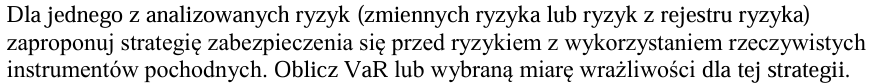

# Proponowana opcja:
Opcje na Jet Fuel (np. na rynku ICE Europe)

In [77]:
#Parametry
S_t = 2.4 #USD/galon - spot paliwa (przybliżona cena rynkowa dla paliw typu diesel czy jet fuel w ostatnich miesiącach np. ICE Europe - typowy poziom z oststnich lat)
K= 2.5 #USD/galon -  cena wykonania opcji (out-of-the-money)
T = 0.25 #[roku] - czas do wygaśnięcia w latach (standardowy horyzont wyceni opcji - popularny termin kontraktów forward i opcji)
r = 0.03 #stopa wolna od ryzyka (przykładowa zbliżona do rentowności obligacji skarbowych USA czy UE z ostatnich lat)
sigma = fuel_data.std() #zmienność roczna (na bazie dancyh)

#Liczba galonów
n = 10000

Wycena opcji na paliwo – model Blacka-Scholesa

In [78]:
d1 = (np.log(S_t/K) + (r + sigma**2/2 )*T)/(sigma*np.sqrt(T))
d2 = d1 - sigma*np.sqrt(T)

C = S_t*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)
C_n = C*n
C_approx = round(C_n, -2) 

print(f"Cena pojedynczej opcji kupna na paliwo: {C:.4f} USD")
print(f"A cena za {n} galonów: {C_n:.4f} USD ~ {C_approx} USD")


Cena pojedynczej opcji kupna na paliwo: 0.0863 USD
A cena za 10000 galonów: 862.7652 USD ~ 900.0 USD


In [79]:
print("Maksymalna cena paliwa:", max(fuel_data))
print("Minimalna cena paliwa:", min(fuel_data))
print("Średnia cen paliwa:", (fuel_data).mean())


Maksymalna cena paliwa: 2.851599931716919
Minimalna cena paliwa: 1.919999957084656
Średnia cen paliwa: 2.258124203909011


In [80]:
ceny_rynkowe = np.arange(2.0, 3.0 + 0.01, 0.1)

brak_zabezpieczenia = ceny_rynkowe*n

cena_futures = 2.4 
futures = [cena_futures*n for _ in range(len(ceny_rynkowe))]

opcja_kupna = []
cen_wykonania_opcji = K
for cena in ceny_rynkowe:
    if cena < cen_wykonania_opcji:
        opcja_kupna.append(cena*n + C_approx)
    else:
        opcja_kupna.append(cen_wykonania_opcji*n + C_approx)
        
print(f"Cena forward za {cena_futures} USD/galon")
print(f"Cena wykonania opcji kupna za {cen_wykonania_opcji} USD/galon")
        

Cena forward za 2.4 USD/galon
Cena wykonania opcji kupna za 2.5 USD/galon


In [81]:
# Tworzenie DataFrame
df = pd.DataFrame({
    'ceny_rynkowe': ceny_rynkowe,
    'brak_zabezpieczenia': brak_zabezpieczenia,
    'cena_futures': cena_futures,
    'futures': futures,
    'opcja_kupna': opcja_kupna
})

df

,ceny_rynkowe,brak_zabezpieczenia,cena_futures,futures,opcja_kupna
0,2.0,20000.0,2.4,24000.0,20900.0
1,2.1,21000.0,2.4,24000.0,21900.0
2,2.2,22000.0,2.4,24000.0,22900.0
3,2.3,23000.0,2.4,24000.0,23900.0
4,2.4,24000.0,2.4,24000.0,24900.0
5,2.5,25000.0,2.4,24000.0,25900.0
6,2.6,26000.0,2.4,24000.0,25900.0
7,2.7,27000.0,2.4,24000.0,25900.0
8,2.8,28000.0,2.4,24000.0,25900.0
9,2.9,29000.0,2.4,24000.0,25900.0


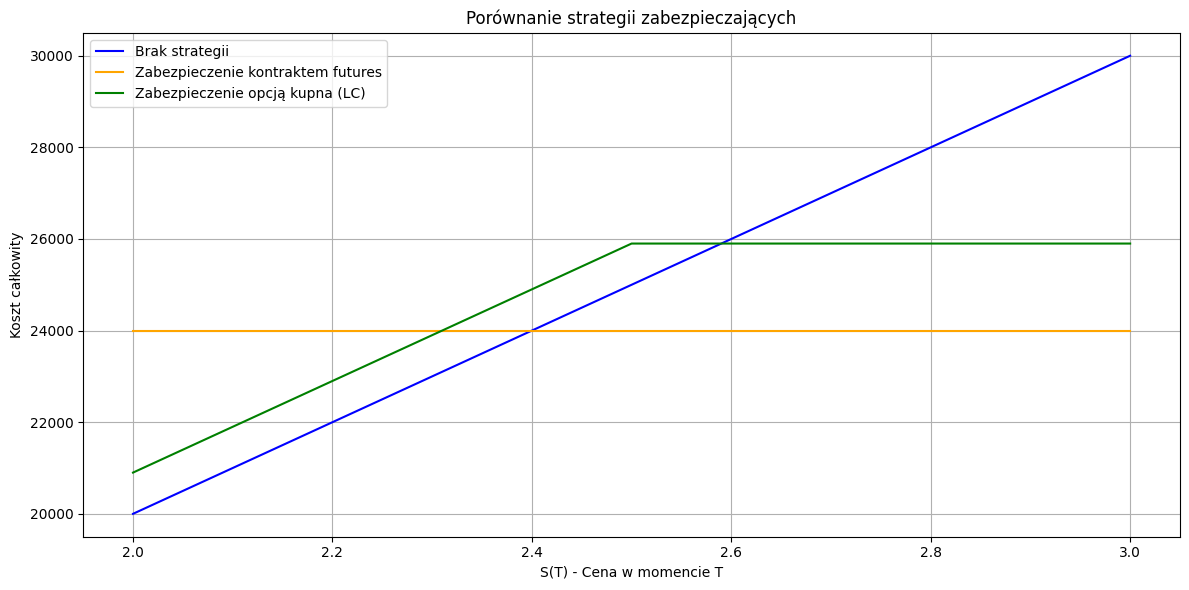

In [82]:
import matplotlib.pyplot as plt
import pandas as pd

plt.figure(figsize=(12, 6))

# Wykresy dla każdej strategii
plt.plot(df['ceny_rynkowe'], df['brak_zabezpieczenia'], label='Brak strategii', color='blue')
plt.plot(df['ceny_rynkowe'], df['futures'], label='Zabezpieczenie kontraktem futures', color='orange')
plt.plot(df['ceny_rynkowe'], df['opcja_kupna'], label='Zabezpieczenie opcją kupna (LC)', color='green')

# Oznaczenia osi i tytuł
plt.xlabel('S(T) - Cena w momencie T')
plt.ylabel('Koszt całkowity')
plt.title('Porównanie strategii zabezpieczających')

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [83]:
#VaR sposobem z maila
var_p_1 = round(np.quantile(brak_zabezpieczenia, 0.95), 2)
var_p_2 = round(np.quantile(futures, 0.95), 2)
var_p_3 = round(np.quantile(opcja_kupna, 0.95), 2)

print(f'VaR całkowitego kosztu 95% - brak strategii: {var_p_1/n}')
print(f'VaR całkowitego kosztu 95% - zabezpieczenie futures: {var_p_2}')
print(f'VaR całkowitego kosztu 95% - zabezpieczenie opcją: {var_p_3}')

VaR całkowitego kosztu 95% - brak strategii: 2.95
VaR całkowitego kosztu 95% - zabezpieczenie futures: 24000.0
VaR całkowitego kosztu 95% - zabezpieczenie opcją: 25900.0


$$
\text{VaR}_{\alpha} = \text{z}_{\alpha} \cdot \sigma_{\text{return}} \cdot S_t \cdot \sqrt{252}
$$

In [84]:
#VaR dla opcji kupna
std_return = fuel_returns.std()

VaR_95 = norm.ppf(0.95) * std_return* S_t * np.sqrt(252)
VaR_95_total = VaR_95 * n

VaR_99 = norm.ppf(0.99) * std_return* S_t * np.sqrt(252)
VaR_99_total = VaR_99 * n

print(f"Jednodniowy VaR (95%): {VaR_95:.4f} USD/galon")
print(f"Jednodniowy VaR łączny: {VaR_95_total:.2f} USD")

print(f"Jednodniowy VaR (99%): {VaR_99:.4f} USD/galon")
print(f"Jednodniowy VaR łączny: {VaR_99_total:.2f} USD")

Jednodniowy VaR (95%): 1.0567 USD/galon
Jednodniowy VaR łączny: 10566.78 USD
Jednodniowy VaR (99%): 1.4945 USD/galon
Jednodniowy VaR łączny: 14944.80 USD


In [85]:
#VaR dla kontraktu futures
std_return = fuel_returns.std()

VaR_95 = norm.ppf(0.95) * std_return* cena_futures * np.sqrt(252)
VaR_95_total = VaR_95 * n

VaR_99 = norm.ppf(0.99) * std_return* cena_futures * np.sqrt(252)
VaR_99_total = VaR_99 * n

print(f"Jednodniowy VaR (95%): {VaR_95:.4f} USD/galon")
print(f"Jednodniowy VaR łączny: {VaR_95_total:.2f} USD")

print(f"Jednodniowy VaR (99%): {VaR_99:.4f} USD/galon")
print(f"Jednodniowy VaR łączny: {VaR_99_total:.2f} USD")

Jednodniowy VaR (95%): 1.0567 USD/galon
Jednodniowy VaR łączny: 10566.78 USD
Jednodniowy VaR (99%): 1.4945 USD/galon
Jednodniowy VaR łączny: 14944.80 USD


# 2. 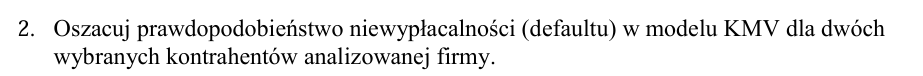

coca cola

In [86]:
import yfinance as yf
import numpy as np
import pandas as pd
from scipy.stats import norm
import numpy as np

ticker = yf.Ticker("KO")
hist = ticker.history(period="1y")
returns = hist['Close'].pct_change().dropna()
sigma_V = returns.std() * np.sqrt(252)


ModuleNotFoundError: No module named 'yfinance'

In [ ]:
V = ticker.info['marketCap']
D = ticker.balance_sheet.loc["Net Debt"].iloc[0]

r = 0.03  # stopa wolna od ryzyka
T = 1     # rok

DD = (np.log(V / D) + (r - 0.5 * sigma_V**2) * T) / (sigma_V * np.sqrt(T))
PD = norm.cdf(-DD)

print(f"Distance to Default: {DD:.4f}")
print(f"Probability of Default: {PD:.4%}")


Distance to Default: 12.9582
Probability of Default: 0.0000%


Heinz - keczup

In [ ]:
import yfinance as yf
import numpy as np
from scipy.stats import norm

ticker = yf.Ticker("KHC")
hist = ticker.history(period="1y")
returns = hist['Close'].pct_change().dropna()
sigma_V = returns.std() * np.sqrt(252)

V = ticker.info['marketCap']
D = ticker.balance_sheet.loc["Net Debt"].iloc[0]


DD = (np.log(V / D) + (r - 0.5 * sigma_V**2) * T) / (sigma_V * np.sqrt(T))
PD = norm.cdf(-DD)
print(f"Distance to Default: {DD:.4f}")
print(f"Probability of Default: {PD:.4%}")


Distance to Default: 2.1951
Probability of Default: 1.4078%
